In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import least_squares

In [96]:
def average_rows(x,nblock=100):
    nr=x.shape[0]//nblock
    print(x.shape[0],nr)
    nc=x.shape[1]
    y=np.zeros((nr,nc),dtype=x.dtype)
    for i in range(nr):
        y[i,:]=np.mean(x[i*nblock:(i+1)*nblock],axis=0)
    return y

In [128]:
def get_adev(x,tau,stidx=0,endidx=None):
    dt=4096/250e6
    delta=int(tau/dt)
#     print(delta)
    sl=slice(stidx,endidx,delta)
    samps=x[sl]
#     print(samps)
    adev=dt*np.sqrt(np.mean((samps[2:]-2*samps[1:-1]+samps[:-2])**2)/(2*tau**2))
    return adev

In [126]:
# with np.load("../data/spectra_1830_1840_4096_100_clock_with_1overf_2.npz") as f:
#     spec1=f['spectra1']
#     spec2=f['spectra2']
#     delays=f['delays']
with np.load("../data/spectra_1830_1840_4096_2000_0.1_clock_with_1overf.npz") as f:
    spec1=f['spectra1']
    spec2=f['spectra2']
    delays=f['delays']

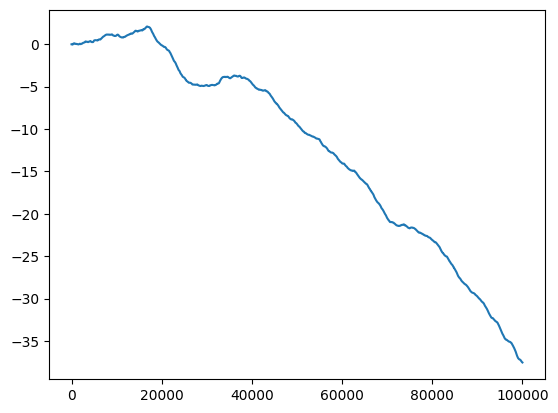

In [140]:
st=0
plt.plot(-2*np.pi*1834*delays[st:100000]/4096)


1000000 100


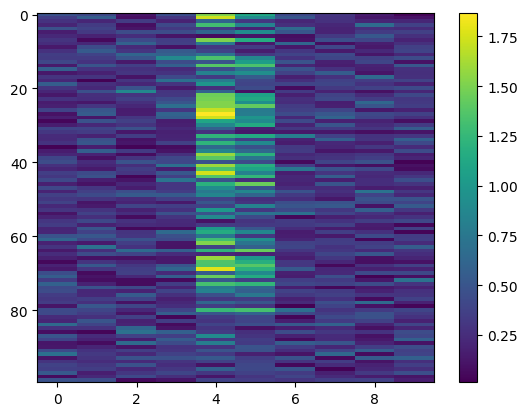

In [165]:
xc=spec1[:,:]*np.conj(spec2[:,:])
avglen=10000
xc_avg=average_rows(xc,nblock=avglen)
plt.imshow(np.abs(xc_avg),aspect='auto',interpolation='None')
plt.colorbar()

In [166]:
noiser = np.std(xc_avg[:,[0,1,2,6,7,8,9]].real)
noiseim = np.std(xc_avg[:,[0,1,2,6,7,8,9]].imag)
signal = np.std(xc_avg[:,[4]].real)
# print(signal/noise)
print(noiser, noiseim)
print(signal)

0.24303881233729774 0.22873290845346692
0.7517819042211186


In [59]:
2*np.pi*1834/4096 * 1e-7

2.813320764982266e-07

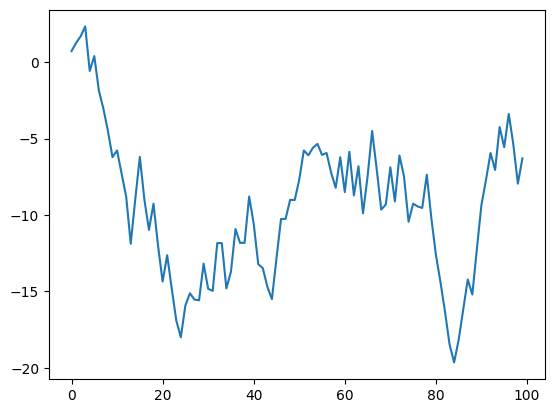

In [143]:
plt.plot(np.unwrap(np.angle(xc_avg[:,4])))
# plt.plot(-2*np.pi*1834*delays[0:]/4096)

In [129]:
taus=10**np.linspace(-3,0,101)
# taus=np.linspace(0.1,2,1001)
adevs=np.zeros(len(taus))
for i,tau in enumerate(taus):
    adevs[i]=get_adev(delays,tau)

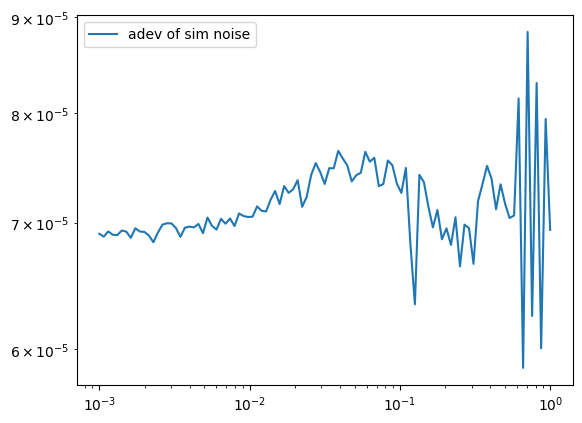

In [130]:
plt.loglog(taus,adevs,label='adev of sim noise')
# params=np.polyfit(np.log10(taus), np.log10(adevs),2)
# plt.loglog(taus,10**np.polyval(params,np.log10(taus))*4e-9,label='quadratic fit')
plt.legend()
#4 to 5 OOM worse than actual LB ADEV. 

In [139]:
6e-7*1e-2/4e-9 #rough error in number of samples tau * adev(tau), for about 1000 spectra.

1.5

m in spec/spec 4.6683161043122074e-08
m in ADC samp/spec 0.00019121422763262801


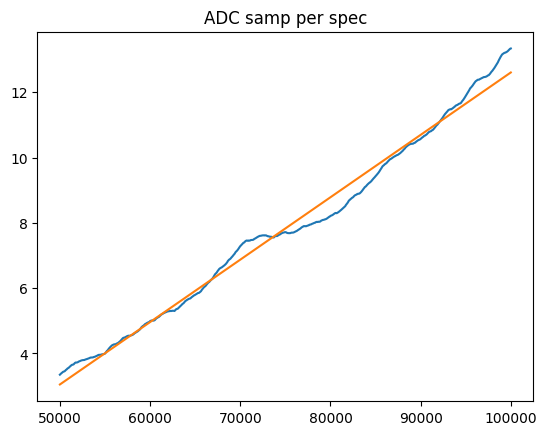

In [217]:
st=50000
en=st+50000
plt.plot(np.arange(st,en),delays[st:en])
m,c=np.polyfit(np.arange(st,en),delays[st:en],1)
plt.title("ADC samp per spec")
# m,c=np.polyfit(np.arange(0,en-st),delays[st:en]-delays[st],1)
print("m in spec/spec", m/4096)
print("m in ADC samp/spec", m)
plt.plot(np.arange(st,en), np.arange(st,en)*m+c)
# plt.xlim(20000,50000)

In [127]:
1/(10000 * 1834) * 4096 #adc samp per spec

0.00022333696837513632

In [130]:
#resolution with 50000 fft size is
1/(10000 * 1834) #min slope in units of spec/spec

5.4525627044711016e-08

In [ ]:
1/(50000 * 1834) * 4096/250e6 #slope units seconds per spectrum; minimum detectable by FFT length

1.7866957470010905e-13

In [ ]:
def newton(n,xc,alpha,chan,scale=1):
    c=2*np.pi*chan
    N=len(xc)
    xc_phased = xc*np.exp(1j*c*n*alpha) #n is specnum
    S0conj=np.conj(np.mean(xc_phased))
    S1=np.mean(xc_phased*n*c)
    S2=np.mean(xc_phased*n**2*c**2)
    df=-np.imag(S0conj*S1)
    ddf=-np.real(S0conj*S2) + np.abs(S1)**2
    alpha2 = alpha - scale*df/ddf
    print(f"old alpha {alpha:5.3e}, df {df:5.3e}, ddf {ddf:5.3e}, step size {df/ddf:5.3e} new alpha {alpha2:5.3e} ")
    return alpha2

def lmsolver(xc,alpha,chan,scale=1,lamda=16,xtol=1e-6,ftol=1e-6,niter=10):
    c=2*np.pi*chan
    N=len(xc)
    n = np.arange(N)
    lamda=lamda
    for ii in range(niter):
        print(f"------------------------------ LM iter {ii} -------------------------------")
        xc_phased = 1e-5*xc*np.exp(1j*c*n*alpha) #n is specnum
        f = -np.abs(np.mean(xc_phased))**2
        S0conj=np.conj(np.mean(xc_phased))
        S1=np.mean(xc_phased*n*c)
        S2=np.mean(xc_phased*n**2*c**2)
        # print(np.abs(S0conj), np.abs(S1), np.abs(S2))
        df = np.imag(S0conj*S1)
        ddf = np.real(S0conj*S2) - np.abs(S1)**2
        step = - df/(ddf + lamda*np.abs(ddf))
        # step = - 1e-3 * df
        alpha2 = alpha + step
        # 
        # f22 = -np.mean(np.abs(xc_phased)**2)
        xc_phased = 1e-5*xc*np.exp(1j*c*n*alpha2)
        f2 = -np.abs(np.mean(xc_phased))**2
        # print(f,f2,alpha,alpha2)
        print(f"lamda: {lamda:5.3e} alpha: {alpha:5.3e} f: {f:5.3e}, df: {df:5.3e}, ddf: {ddf:5.3e}, step: {step:5.3e}, alpha2: {alpha2:5.3e} f2: {f2:5.3e}")
        if f2 < f: #proceeding towards minimization
            #accept
            
            print("accepting...")
            rel_alpha = (alpha2-alpha)/alpha
            rel_f = (f2-f)/f
            print(f"rel alpha: {np.abs(rel_alpha):5.3e} rel f: {np.abs(rel_f):5.3e}")
            alpha = alpha2
            lamda/=2
            if np.abs(rel_alpha) < xtol or np.abs(rel_f) < ftol:
                print("converged.")
                return alpha
        else:
            lamda*=2
    raise Exception(f"Failed to converge in {niter} iterations.")
    return alpha


def solver(xc,alpha,chan,scale=1,atol=1e-10,rtol=1e-6,niter=10):
    niter=niter
    success=0
    N=len(xc)
    n = np.arange(N)
    for i in range(niter):
        alpha2=newton(n,xc,alpha,chan,scale=scale)
        if np.abs(alpha2) < atol:
            print("atol hit")
            success=1
            break
        if np.abs((alpha2-alpha)/alpha) < rtol:
            print("rtol hit")
            success=1
            break
        alpha=alpha2
    if not success:
        print("Max iterations, unsuccessful.")
    return alpha2

In [40]:
def objective_func(xc,alpha,chan):
    c=2*np.pi*chan
    N=len(xc)
    n=np.arange(N)
    xc_phased = xc*np.exp(1j*c*n*alpha)
    return np.abs(np.mean(xc_phased))**2

def get_derivs(xc,alpha,chan):
    c=2*np.pi*chan
    N=len(xc)
    n=np.arange(N)
    xc_phased = xc*np.exp(1j*c*n*alpha)
    S0conj=np.conj(np.mean(xc_phased))
    S1=np.mean(xc_phased*n*c)
    S2=np.mean(xc_phased*n**2*c**2)
    df=-np.imag(S0conj*S1)
    ddf=-np.real(S0conj*S2) + np.abs(S1)**2
    return df, ddf

In [218]:
y1=spec1[st:en,4]
y2=spec2[st:en,4]
xc_small = y1*np.conj(y2)
print(np.mean(xc_small))
 #* np.exp(-1j*np.angle(xc_small)[0]) #a constant phase offset is not what we care about

(-0.15702833050497852+0.1610947304585566j)


In [28]:
(1.32-1.18)*1e-7/5000

2.8000000000000022e-12

50000
Max at -4.0
Expected delta (ADC/spec)= -0.00017866957470010907
Expected delta (spec/spec)= -4.3620501635768816e-08


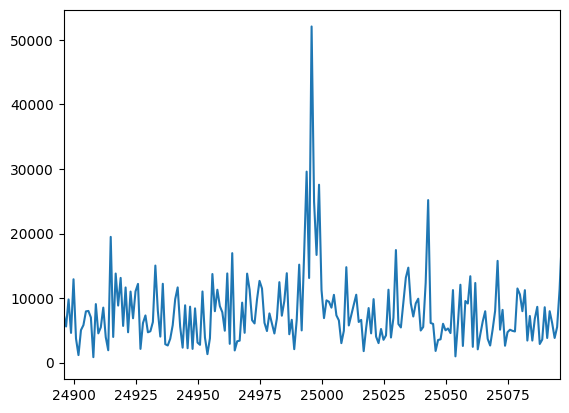

In [219]:
#take an fft to see which value to try.
xc_fft = np.fft.fftshift(np.abs(np.fft.fft(xc_small))) # should peak at -ve freq cause deltat is 2.5e-4, and fft is exp(-jomega t)
mm=np.argmax(xc_fft)
plt.plot(xc_fft)
plt.xlim(mm-100,mm+100)
M=len(xc_fft)
print(M)
print("Max at", mm-len(xc_fft)/2)
expected_delta = (mm-M/2)/M * (4096/1834)
print("Expected delta (ADC/spec)=", expected_delta)
print("Expected delta (spec/spec)=", expected_delta/4096)

In [176]:
xc_small.shape

(6400,)

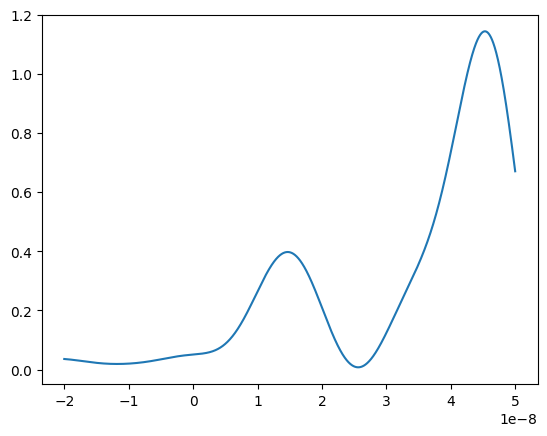

In [221]:


alphas=np.linspace(-2e-8,5e-8,10001)
f_alpha = np.zeros(len(alphas))
df = f_alpha.copy()
ddf = f_alpha.copy()
for i in range(len(f_alpha)):
    f_alpha[i] = objective_func(xc_small,alphas[i],1834)
    df[i], ddf[i] = get_derivs(xc_small,alphas[i],1834)
plt.plot(alphas,f_alpha)


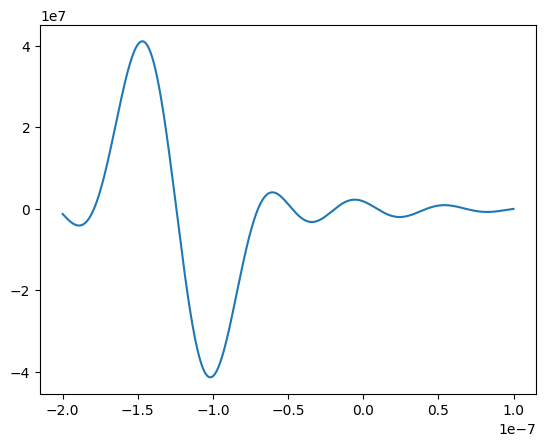

In [19]:
plt.plot(alphas,df)

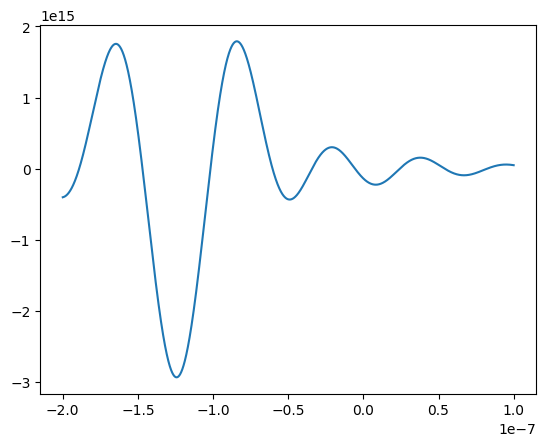

In [20]:
plt.plot(alphas,ddf)
# plt.xlim(-1.5e-10,1.5e-10)

In [53]:
c=2*np.pi*1834
print(np.abs(np.mean(xc_small*np.exp(1j*c*np.arange(len(xc_small))*(-1e-7))))**2)
print(np.abs(np.mean(xc_small*np.exp(1j*c*np.arange(len(xc_small))*(-1.4e-7))))**2)

1.30805303628075
2.0102176589112286


In [ ]:
print(objective_func(xc_small,-1e-7,1834))
print(objective_func(xc_small,-1.4e-7,1834))


0.01211785462814272
0.013105919859759294
0.08384639008572264


In [ ]:
# Pure Newton
alpha=-1.25e-7
solver(xc_small,alpha,1834,rtol=1e-6,atol=1e-16,niter=100)

old alpha -1.250e-07, df 1.888e+06, ddf -2.931e+15, step size -6.441e-10 new alpha -1.244e-07 
old alpha -1.244e-07, df -1.639e+03, ddf -2.935e+15, step size 5.585e-13 new alpha -1.244e-07 
old alpha -1.244e-07, df -1.876e-04, ddf -2.935e+15, step size 6.392e-20 new alpha -1.244e-07 
rtol hit


np.float64(-1.2435644332655214e-07)

In [222]:
#Lev-Marq
alpha=4.36e-8
lmsolver(xc_small,alpha,1834,lamda=10,ftol=1e-8,xtol=1e-8,niter=100)

------------------------------ LM iter 0 -------------------------------
lamda: 1.000e+01 alpha: 4.360e-08 f: -1.083e-10, df: -3.324e-03, ddf: 1.543e+06, step: 1.958e-10, alpha2: 4.380e-08 f2: -1.096e-10
accepting...
rel alpha: 4.492e-03 rel f: 1.146e-02
------------------------------ LM iter 1 -------------------------------
lamda: 5.000e+00 alpha: 4.380e-08 f: -1.096e-10, df: -3.011e-03, ddf: 1.651e+06, step: 3.040e-10, alpha2: 4.410e-08 f2: -1.112e-10
accepting...
rel alpha: 6.942e-03 rel f: 1.527e-02
------------------------------ LM iter 2 -------------------------------
lamda: 2.500e+00 alpha: 4.410e-08 f: -1.112e-10, df: -2.485e-03, ddf: 1.809e+06, step: 3.926e-10, alpha2: 4.449e-08 f2: -1.129e-10
accepting...
rel alpha: 8.901e-03 rel f: 1.495e-02
------------------------------ LM iter 3 -------------------------------
lamda: 1.250e+00 alpha: 4.449e-08 f: -1.129e-10, df: -1.738e-03, ddf: 1.992e+06, step: 3.878e-10, alpha2: 4.488e-08 f2: -1.139e-10
accepting...
rel alpha: 8.716e-

np.float64(4.530274255445978e-08)

In [204]:
print(objective_func(xc_small,0,1834) )
print(objective_func(xc_small,-4.9e-9,1834) )
print(objective_func(xc_small,1.7e-8,1834))

0.6815323804957425
1.0409082327989043
0.3727767883353554


In [182]:
1e6/6400

156.25

In [224]:
#iterate over several blocks and fit a line
blocksize=50000
st=0
# nblocks=spec1.shape[0]//blocksize
nblocks=20
print("Num blocks are", nblocks)
en=blocksize*nblocks
fit_delta=np.zeros(nblocks,dtype='float64')
actual_delta = np.zeros(nblocks,dtype='float64')
for i in range(nblocks):
    #fft and get a coarse guess
    ix=st+i*blocksize
    print("taking data from ", ix, ix+blocksize)
    y1=spec1[ix:ix+blocksize,4]
    y2=spec2[ix:ix+blocksize,4]
    xc_small = y1*np.conj(y2)
    xc_fft = np.fft.fftshift(np.abs(np.fft.fft(xc_small)))
    mm=np.argmax(xc_fft)
    # plt.plot(xc_fft)
    # plt.xlim(mm-100,mm+100)
    M=len(xc_fft)
    # print(M)
    print("Max at", (mm-M/2)/M /1834)
    expected_delta = (mm-M/2)/M /1834
    if np.abs(expected_delta) < 1e-15: expected_delta = 1e-15
    print("Starting point", -expected_delta)
    # print(f"Block {i} Expected delta={expected_delta}")
    alpha=lmsolver(xc_small,-expected_delta,1834,lamda=10,ftol=1e-8,xtol=1e-8,niter=100)
    fit_delta[i]=alpha
    # plt.title(f"Block {i}")
    # plt.plot(delays[ix:ix+blocksize])
    # plt.show()

    m,c=np.polyfit(np.arange(ix,ix+blocksize),delays[ix:ix+blocksize],1)
    # m,c=np.polyfit(np.arange(0,en-st),delays[st:en]-delays[st],1)
    print(f"block {i} slope", m/4096, "pred slope", alpha)
    actual_delta[i] = m/4096

Num blocks are 20
taking data from  0 50000
Max at 0.0
Starting point -1e-15
------------------------------ LM iter 0 -------------------------------
lamda: 1.000e+01 alpha: -1.000e-15 f: -6.815e-11, df: 5.184e-03, ddf: -5.042e+04, step: -1.142e-08, alpha2: -1.142e-08 f2: -2.870e-11
------------------------------ LM iter 1 -------------------------------
lamda: 2.000e+01 alpha: -1.000e-15 f: -6.815e-11, df: 5.184e-03, ddf: -5.042e+04, step: -5.411e-09, alpha2: -5.411e-09 f2: -1.036e-10
accepting...
rel alpha: 5.411e+06 rel f: 5.205e-01
------------------------------ LM iter 2 -------------------------------
lamda: 1.000e+01 alpha: -5.411e-09 f: -1.036e-10, df: -1.049e-03, ddf: 2.356e+06, step: 4.047e-11, alpha2: -5.371e-09 f2: -1.037e-10
accepting...
rel alpha: 7.479e-03 rel f: 7.818e-04
------------------------------ LM iter 3 -------------------------------
lamda: 5.000e+00 alpha: -5.371e-09 f: -1.037e-10, df: -9.534e-04, ddf: 2.349e+06, step: 6.766e-11, alpha2: -5.303e-09 f2: -1.038

(-6e-08, 1e-07)

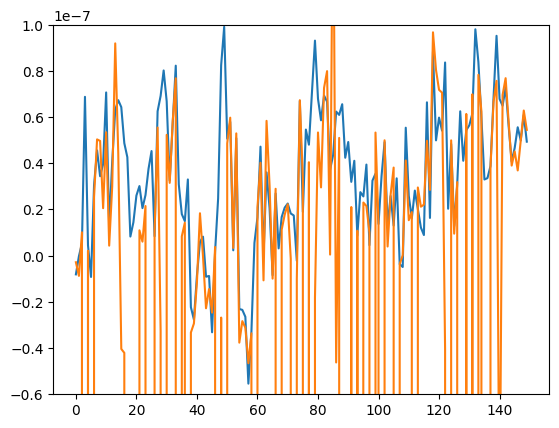

In [193]:
plt.plot(actual_delta)
plt.plot(fit_delta)
plt.ylim(-6e-8,1e-7)

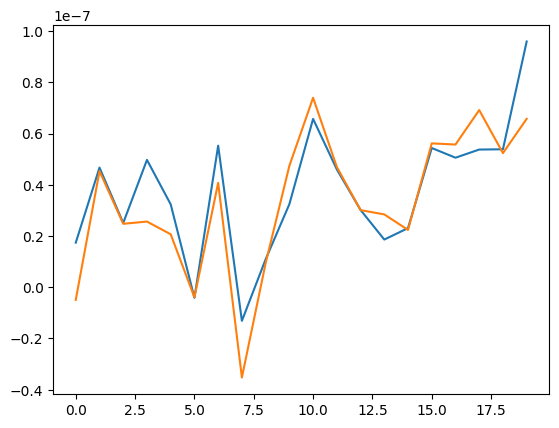

In [225]:
plt.plot(actual_delta)
plt.plot(fit_delta)
# plt.ylim(-6e-8,1e-7)

np.float64(0.9)

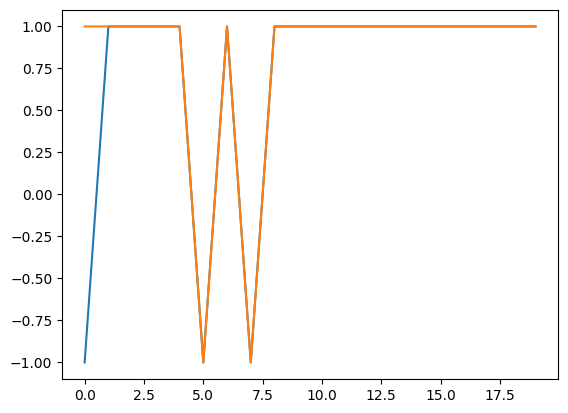

In [226]:
plt.plot(np.sign(fit_delta))
plt.plot(np.sign(actual_delta))
np.mean(np.sign(fit_delta)*np.sign(actual_delta))

In [214]:
fit_delta
actual_delta

array([ 1.73690744e-08,  4.66831610e-08,  2.50668313e-08,  4.96948344e-08,
        3.23414155e-08, -4.17063502e-09,  5.52352690e-08, -1.31555682e-08,
        1.08542373e-08,  3.23922136e-08,  6.57029485e-08,  4.59893312e-08,
        3.01424590e-08,  1.85834205e-08,  2.30473215e-08,  5.43352455e-08,
        5.05485436e-08,  5.37314639e-08,  5.38369450e-08,  9.59372563e-08])

In [228]:
#iterate over several blocks and fit a line
blocksize=50000
st=0
nblocks=20
n = np.arange(0,blocksize)
tot=0+0j
for i in range(nblocks):
    #fft and get a coarse guess
    ix=st+i*blocksize
    y1=spec1[ix:ix+blocksize,4]
    y2=spec2[ix:ix+blocksize,4]
    xc_small = y1*np.conj(y2)
    xc_corrected1 = xc_small * np.exp(2j*np.pi*1834*n*fit_delta[i])
    xc_corrected2 = xc_small * np.exp(2j*np.pi*1834*n*actual_delta[i])
    print(np.abs(np.mean(xc_corrected1))>np.abs(np.mean(xc_corrected2)))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
pred_drift=np.zeros(nblocks*blocksize)
t = np.arange(blocksize)
for i in range(nblocks):
    pred_drift[i*blocksize : (i+1)*blocksize] = pred_drift[i*blocksize-1] - 2*np.pi*1834*t*fit_delta[i]/4096